# Uncovering the network

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from operator import itemgetter
import community as c
import operator

**Define a function to process the XML file.** Input: XML file; Output: dataframe (col: nameOfIssuer, cusip, sshPrnamt)

In [2]:
def parseXML(XMLfile):
    tree =  ET.parse(XMLfile)
    root = tree.getroot()
    dict = {'nameOfIssuer': [],
        'cusip': [],
        'sshPrnamt': []}
    for i in range(len(root)):
        dict['nameOfIssuer'].append(root[i][0].text)
        dict['cusip'].append(root[i][2].text)
        dict['sshPrnamt'].append(root[i][4][0].text)
    df = pd.DataFrame(dict)
    df['sshPrnamt'] = df['sshPrnamt'].astype(int)
    df_sum = df.groupby('nameOfIssuer', as_index=False)['sshPrnamt'].agg('sum')
    return df_sum

# Data preparation

Parse xml files.

In [3]:
## 2020q4
BerkshireHathawayInc2020q4 = parseXML('BerkshireHathawayInc-2020q4.xml')
BridgewaterAssociates2020q4 = parseXML('BridgewaterAssociates-2020q4.xml')
Jpmorgan2020q4 = parseXML('Jpmorgan-2020q4.xml')
RENAISSANCE2020q4 = parseXML('RENAISSANCE-2020q4.xml')
TwoSigma2020q4 = parseXML('TwoSigma-2020q4.xml')

## 2021q1
BerkshireHathawayInc2021q1 = parseXML('BerkshireHathawaInc-2021q1.xml')
BridgewaterAssociates2021q1 = parseXML('BridgewaterAssociates-2021q1.xml')
Jpmorgan2021q1 = parseXML('Jpmorgan-2021q1.xml')
RENAISSANCE2021q1 = parseXML('RENAISSANCE-2021q1.xml')
TwoSigma2021q1 = parseXML('TwoSigma-2021q1.xml')

Rename column names.

In [4]:
## 2020q4
BerkshireHathawayInc2020q4['shareHolder']='Berkshire Hathaway Inc'
BridgewaterAssociates2020q4['shareHolder']='Bridgewater Associates'
Jpmorgan2020q4['shareHolder']='Jpmorgan'
RENAISSANCE2020q4['shareHolder']='RENAISSANCE'
TwoSigma2020q4['shareHolder']='TwoSigma'

## 2021q1
BerkshireHathawayInc2021q1['shareHolder']='Berkshire Hathaway Inc'
BridgewaterAssociates2021q1['shareHolder']='Bridgewater Associates'
Jpmorgan2021q1['shareHolder']='Jpmorgan'
RENAISSANCE2021q1['shareHolder']='RENAISSANCE'
TwoSigma2021q1['shareHolder']='TwoSigma'

Append data together.

In [5]:
## 2020q4
df_all_2020q4 = pd.DataFrame()

for i in [BerkshireHathawayInc2020q4, BridgewaterAssociates2020q4, Jpmorgan2020q4, RENAISSANCE2020q4, TwoSigma2020q4]:
    df_all_2020q4 = df_all_2020q4.append(i)

df_all_2020q4 = df_all_2020q4.reset_index(drop=True)

## 2021q1
df_all_2021q1 = pd.DataFrame()

for i in [BerkshireHathawayInc2021q1, BridgewaterAssociates2021q1, Jpmorgan2021q1, RENAISSANCE2021q1, TwoSigma2021q1]:
    df_all_2021q1 = df_all_2021q1.append(i)

df_all_2021q1 = df_all_2021q1.reset_index(drop=True)

In [6]:
df_all_2020q4.head()

,nameOfIssuer,sshPrnamt,shareHolder
0,ABBVIE INC,25533082,Berkshire Hathaway Inc
1,AMAZON COM INC,533300,Berkshire Hathaway Inc
2,AMERICAN EXPRESS CO,151610700,Berkshire Hathaway Inc
3,APPLE INC,887135554,Berkshire Hathaway Inc
4,AXALTA COATING SYS LTD,23420000,Berkshire Hathaway Inc


In [7]:
df_all_2021q1.head()

,nameOfIssuer,sshPrnamt,shareHolder
0,ABBVIE INC,22868178,Berkshire Hathaway Inc
1,AMAZON COM INC,533300,Berkshire Hathaway Inc
2,AMERICAN EXPRESS CO,151610700,Berkshire Hathaway Inc
3,AON PLC,4096146,Berkshire Hathaway Inc
4,APPLE INC,887135554,Berkshire Hathaway Inc


Nodes in graphs.

In [8]:
nodes2020q4 = pd.concat([df_all_2020q4['nameOfIssuer'],pd.DataFrame(df_all_2020q4['shareHolder'].unique())]).rename(columns = {0: 'node'}, inplace = False).reset_index(drop=True)
nodes2021q1 = pd.concat([df_all_2021q1['nameOfIssuer'],pd.DataFrame(df_all_2021q1['shareHolder'].unique())]).rename(columns = {0: 'node'}, inplace = False).reset_index(drop=True)

# Undirected Network 2020q4

Create graph.

In [9]:
G2020q4 = nx.Graph()

Add edges with shares.

In [10]:
for i in df_all_2020q4.index:
    edge = df_all_2020q4.iloc[i,]
    G2020q4.add_edge(edge['shareHolder'],edge['nameOfIssuer'],shares=edge['sshPrnamt'])

Plot graphs.

<IPython.core.display.Javascript object>


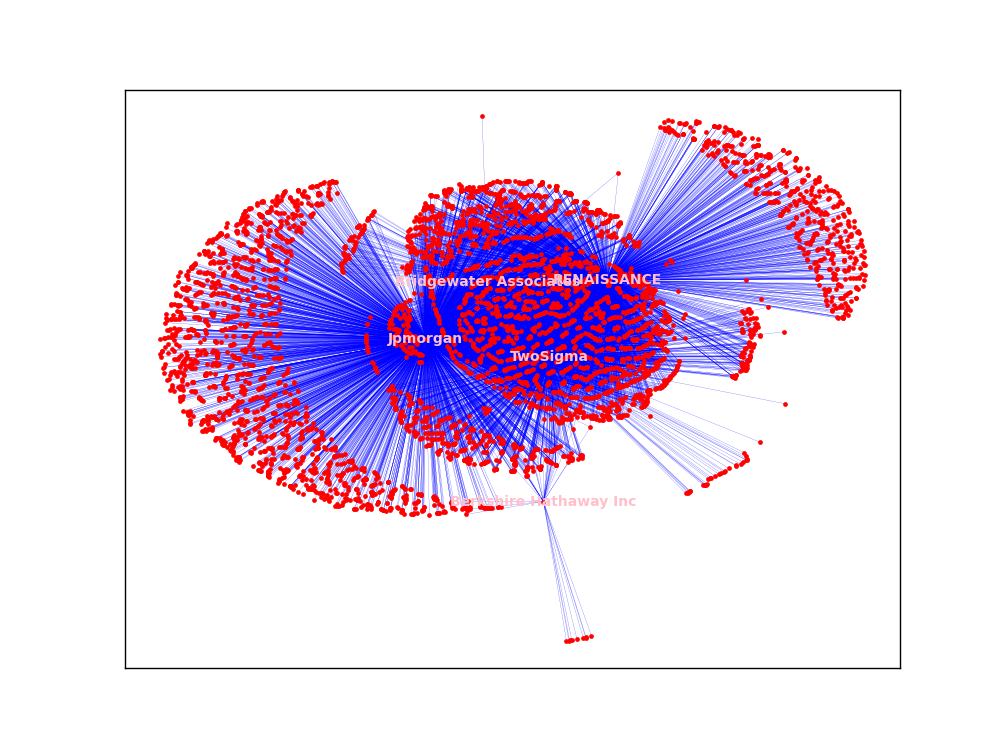

In [11]:
holders = ['Berkshire Hathaway Inc','Bridgewater Associates','Jpmorgan','RENAISSANCE','TwoSigma']

labels = {}   

for node in G2020q4.nodes():
    if node in holders:
        #set the node name as the key and the label as its value 
        labels[node] = node

plt.figure(figsize=(8,6))
nx.draw_networkx(G2020q4,node_color='red',edge_color='blue',font_color='pink',font_weight='bold',pos=nx.spring_layout(G2020q4),width=0.1,node_size=3,with_labels=True,labels=labels,font_size=8) 

## Centrality

### Degree centrality

In [12]:
degree_cent2020q4 = nx.degree_centrality(G2020q4)
sort_degree_cent2020q4 = sorted(degree_cent2020q4.items(), key=itemgetter(1), reverse=True)
sort_degree_cent2020q4[:10]

[('Jpmorgan', 0.8752537368518177),
 ('RENAISSANCE', 0.5763055914375346),
 ('TwoSigma', 0.3989665990035062),
 ('Bridgewater Associates', 0.09503598449898505),
 ('Berkshire Hathaway Inc', 0.008119579258165713),
 ('ABBVIE INC', 0.0009226794611551947),
 ('KROGER CO', 0.0009226794611551947),
 ('LIBERTY GLOBAL PLC', 0.0009226794611551947),
 ('US BANCORP DEL', 0.0009226794611551947),
 ('AMAZON COM INC', 0.0007381435689241557)]

Group by degree centrality.

In [13]:
deg_cen2020q4=pd.DataFrame(sort_degree_cent2020q4)
deg_cen2020q4.columns=['company','degreeCentrality']
deg_cen_groupby2020q4 = deg_cen2020q4.groupby(['degreeCentrality']).count().reset_index()
deg_cen_groupby2020q4

,degreeCentrality,company
0,0.000185,2138
1,0.000369,1669
2,0.000554,1325
3,0.000738,279
4,0.000923,4
5,0.008120,1
6,0.095036,1
7,0.398967,1
8,0.576306,1
9,0.875254,1


In [14]:
# companies invested by 5 inverstment companies
deg_cen2020q4[deg_cen2020q4.degreeCentrality == sorted(deg_cen2020q4.degreeCentrality.unique())[4]]

,company,degreeCentrality
5,ABBVIE INC,0.000923
6,KROGER CO,0.000923
7,LIBERTY GLOBAL PLC,0.000923
8,US BANCORP DEL,0.000923


In [15]:
# companies invested by 4 inverstment companies
deg_cen2020q4[deg_cen2020q4.degreeCentrality == sorted(deg_cen2020q4.degreeCentrality.unique())[3]]

,company,degreeCentrality
9,AMAZON COM INC,0.000738
10,APPLE INC,0.000738
11,AXALTA COATING SYS LTD,0.000738
12,BIOGEN INC,0.000738
13,BRISTOL-MYERS SQUIBB CO,0.000738
...,...,...
283,ZIONS BANCORPORATION N A,0.000738
284,ZOETIS INC,0.000738
285,ZOOM VIDEO COMMUNICATIONS IN,0.000738
286,ZSCALER INC,0.000738


In [16]:
# companies invested by 3 inverstment companies
deg_cen2020q4[deg_cen2020q4.degreeCentrality == sorted(deg_cen2020q4.degreeCentrality.unique())[2]]

,company,degreeCentrality
288,AMERICAN EXPRESS CO,0.000554
289,CHARTER COMMUNICATIONS INC N,0.000554
290,GENERAL MTRS CO,0.000554
291,LIBERTY LATIN AMERICA LTD,0.000554
292,STORE CAP CORP,0.000554
...,...,...
1608,ZIX CORP,0.000554
1609,ZOGENIX INC,0.000554
1610,ZUMIEZ INC,0.000554
1611,ZUORA INC,0.000554


In [17]:
# companies invested by 2 inverstment companies
deg_cen2020q4[deg_cen2020q4.degreeCentrality == sorted(deg_cen2020q4.degreeCentrality.unique())[1]]

,company,degreeCentrality
1613,SNOWFLAKE INC,0.000369
1614,T-MOBILE US INC,0.000369
1615,TEVA PHARMACEUTICAL INDS LTD,0.000369
1616,AGILENT TECHNOLOGIES INC,0.000369
1617,AMETEK INC,0.000369
...,...,...
3277,YATRA ONLINE INC,0.000369
3278,YIELD10 BIOSCIENCE INC,0.000369
3279,ZEDGE INC,0.000369
3280,ZK INTL GROUP CO LTD,0.000369


In [18]:
# companies invested by 1 inverstment companies
deg_cen2020q4[deg_cen2020q4.degreeCentrality == sorted(deg_cen2020q4.degreeCentrality.unique())[0]]

,company,degreeCentrality
3282,BANK AMER CORP,0.000185
3283,BANK OF NEW YORK MELLON CORP,0.000185
3284,DAVITA HEALTHCARE PARTNERS I,0.000185
3285,LIBERTY MEDIA CORP DELAWARE,0.000185
3286,MASTERCARD INC,0.000185
...,...,...
5415,UROVANT SCIENCES LTD,0.000185
5416,VANGUARD SPECIALIZED FUNDS,0.000185
5417,VIA OPTRONICS AG,0.000185
5418,VISION MARINE TECHNOLOGIES I,0.000185


### Betweenness Centrality

In [19]:
between_cent2020q4 = nx.betweenness_centrality(G2020q4)
sort_between_cent2020q4 = sorted(between_cent2020q4.items(), key=operator.itemgetter(1), reverse=True)
sort_between_cent2020q4[:10]

[('Jpmorgan', 0.7012648560566406),
 ('RENAISSANCE', 0.29986114445798495),
 ('TwoSigma', 0.09392584214488325),
 ('Bridgewater Associates', 0.004356597614267135),
 ('Berkshire Hathaway Inc', 0.003336430646809856),
 ('ABBVIE INC', 0.00017393446532162497),
 ('KROGER CO', 0.00017393446532162497),
 ('LIBERTY GLOBAL PLC', 0.00017393446532162497),
 ('US BANCORP DEL', 0.00017393446532162497),
 ('AMAZON COM INC', 0.00016563280949722704)]

## Density

In [20]:
density2020q4 = nx.density(G2020q4)
print("Network density:", density2020q4)

Network density: 0.0007209156793542469


## Shortest Path

In [21]:
# Companies invested by both TwoSigma and RENAISSANCE
company_path_TandR2020q4=[p for p in nx.all_shortest_paths(G2020q4, source='TwoSigma', target='RENAISSANCE')]
company_invest_TandR2020q4=pd.DataFrame(company_path_TandR2020q4)
company_invest_TandR2020q4.columns=['TwoSigma','InvestedCompany','RENAISSANCE']
company_invest_TandR2020q4['InvestedCompany']

0             10X GENOMICS INC
1                      111 INC
2                    51JOB INC
3                    89BIO INC
4                  8X8 INC NEW
                 ...          
1498               ZSCALER INC
1499    ZTO EXPRESS CAYMAN INC
1500                ZUMIEZ INC
1501                 ZUORA INC
1502             ZYMEWORKS INC
Name: InvestedCompany, Length: 1503, dtype: object

In [22]:
# Companies invested by both Jpmorgan and RENAISSANCE
company_path_JandR2020q4=[p for p in nx.all_shortest_paths(G2020q4, source='Jpmorgan', target='RENAISSANCE')]
company_invest_JandR2020q4=pd.DataFrame(company_path_JandR2020q4)
company_invest_JandR2020q4.columns=['Jpmorgan','InvestedCompany','RENAISSANCE']
company_invest_JandR2020q4['InvestedCompany']

0                  10X GENOMICS INC
1                           111 INC
2          1ST CONSTITUTION BANCORP
3                   1ST SOURCE CORP
4                  360 DIGITECH INC
                   ...             
2491         ZTO EXPRESS CAYMAN INC
2492                     ZUMIEZ INC
2493                      ZUORA INC
2494                  ZYMEWORKS INC
2495    ZYNERBA PHARMACEUTICALS INC
Name: InvestedCompany, Length: 2496, dtype: object

In [23]:
# Companies invested by both Jpmorgan and TwoSigma
company_path_JandT2020q4=[p for p in nx.all_shortest_paths(G2020q4, source='Jpmorgan', target='TwoSigma')]
company_invest_JandT2020q4=pd.DataFrame(company_path_JandT2020q4)
company_invest_JandT2020q4.columns=['Jpmorgan','InvestedCompany','TwoSigma']
company_invest_JandT2020q4['InvestedCompany']

0             10X GENOMICS INC
1                      111 INC
2         1LIFE HEALTHCARE INC
3                       2U INC
4                        3M CO
                 ...          
2023    ZTO EXPRESS CAYMAN INC
2024                ZUMIEZ INC
2025                 ZUORA INC
2026             ZYMEWORKS INC
2027                 ZYNGA INC
Name: InvestedCompany, Length: 2028, dtype: object

In [24]:
# Companies invested by the three investment companies (Jpmorgan, RENAISSANCE and TwoSigma)
company_invest_JRT=pd.merge(company_invest_JandR2020q4,company_invest_JandT2020q4)
company_invest_JRT['InvestedCompany']

0             10X GENOMICS INC
1                      111 INC
2                    51JOB INC
3                    89BIO INC
4                  8X8 INC NEW
                 ...          
1399               ZSCALER INC
1400    ZTO EXPRESS CAYMAN INC
1401                ZUMIEZ INC
1402                 ZUORA INC
1403             ZYMEWORKS INC
Name: InvestedCompany, Length: 1404, dtype: object

## Shares

In [25]:
# find how many shares does each investment comapny hold for ABBVIE INC
Fund_list = ['Berkshire Hathaway Inc','Bridgewater Associates','Jpmorgan','RENAISSANCE','TwoSigma']
acompany = 'ABBVIE INC'
shares_of_acompany = {'Fund':[],'Company':[],'Shares':[]}

for i in range(len(Fund_list)):
    shares_of_acompany['Fund'].append(Fund_list[i])
    shares_of_acompany['Company'].append(acompany) # choose a company 
    shares_of_acompany['Shares'].append(G2020q4.get_edge_data(Fund_list[i], acompany)['shares']) 
    
shares_of_acompany=pd.DataFrame(shares_of_acompany)
shares_of_acompany.sort_values(by=['Shares'], ascending=False)

,Fund,Company,Shares
2,Jpmorgan,ABBVIE INC,31850595
0,Berkshire Hathaway Inc,ABBVIE INC,25533082
3,RENAISSANCE,ABBVIE INC,6062575
4,TwoSigma,ABBVIE INC,2573838
1,Bridgewater Associates,ABBVIE INC,25294


# Undirected Network 2021q1

Create graph.

In [26]:
G2021q1 = nx.Graph()

Add edges with shares.

In [27]:
for i in df_all_2021q1.index:
    edge = df_all_2021q1.iloc[i,]
    G2021q1.add_edge(edge['shareHolder'],edge['nameOfIssuer'],shares=edge['sshPrnamt'])

<IPython.core.display.Javascript object>


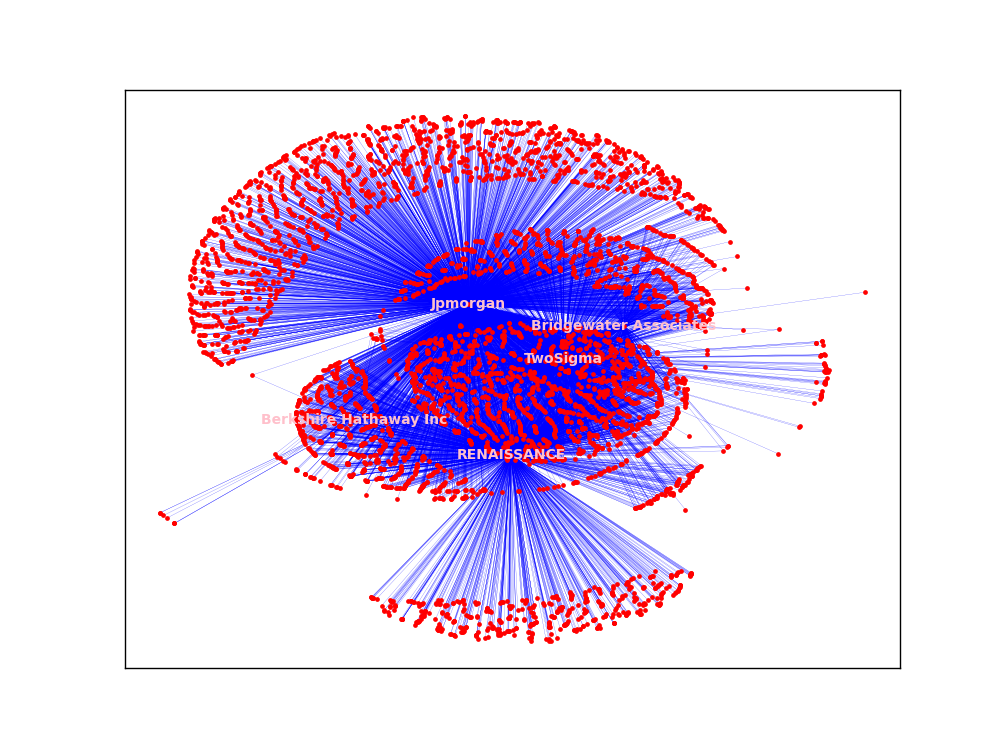

In [28]:
# plot graphs
holders = ['Berkshire Hathaway Inc','Bridgewater Associates','Jpmorgan','RENAISSANCE','TwoSigma']

labels2021q1 = {}   

for node in G2021q1.nodes():
    if node in holders:
        #set the node name as the key and the label as its value 
        labels2021q1[node] = node

plt.figure(figsize=(8,6))
nx.draw_networkx(G2021q1,node_color='red',edge_color='blue',font_color='pink',font_weight='bold',pos=nx.spring_layout(G2021q1),width=0.1,node_size=3,with_labels=True,labels=labels2021q1,font_size=8)

## Centrality

### Degree centrality

In [29]:
degree_cent2021q1 = nx.degree_centrality(G2021q1)
sort_degree_cent2021q1 = sorted(degree_cent2021q1.items(), key=itemgetter(1), reverse=True)
sort_degree_cent2021q1[:10]

[('Jpmorgan', 0.8953835351939617),
 ('RENAISSANCE', 0.5334386519220643),
 ('TwoSigma', 0.4342636475337897),
 ('Bridgewater Associates', 0.07811128664209233),
 ('Berkshire Hathaway Inc', 0.007547832192381956),
 ('AON PLC', 0.000877654906090925),
 ('APPLE INC', 0.000877654906090925),
 ('AXALTA COATING SYS LTD', 0.000877654906090925),
 ('BIOGEN INC', 0.000877654906090925),
 ('BRISTOL-MYERS SQUIBB CO', 0.000877654906090925)]

Group by degree centrality.

In [30]:
deg_cen2021q1=pd.DataFrame(sort_degree_cent2021q1)
deg_cen2021q1.columns=['company','degreeCentrality']
deg_cen_groupby2021q1 = deg_cen2021q1.groupby(['degreeCentrality']).count().reset_index()
deg_cen_groupby2021q1

,degreeCentrality,company
0,0.000176,2264
1,0.000351,1704
2,0.000527,1482
3,0.000702,231
4,0.000878,12
5,0.007548,1
6,0.078111,1
7,0.434264,1
8,0.533439,1
9,0.895384,1


In [31]:
# companies invested by 5 inverstment companies
deg_cen2021q1[deg_cen2021q1.degreeCentrality == sorted(deg_cen2021q1.degreeCentrality.unique())[4]]

,company,degreeCentrality
5,AON PLC,0.000878
6,APPLE INC,0.000878
7,AXALTA COATING SYS LTD,0.000878
8,BIOGEN INC,0.000878
9,BRISTOL-MYERS SQUIBB CO,0.000878
10,COCA COLA CO,0.000878
11,JOHNSON & JOHNSON,0.000878
12,KROGER CO,0.000878
13,MONDELEZ INTL INC,0.000878
14,UNITED PARCEL SERVICE INC,0.000878


In [32]:
# companies invested by 4 inverstment companies
deg_cen2021q1[deg_cen2021q1.degreeCentrality == sorted(deg_cen2021q1.degreeCentrality.unique())[3]]

,company,degreeCentrality
17,ABBVIE INC,0.000702
18,AMAZON COM INC,0.000702
19,CHEVRON CORP NEW,0.000702
20,DAVITA INC,0.000702
21,GENERAL MTRS CO,0.000702
...,...,...
243,WP CAREY INC,0.000702
244,YAMANA GOLD INC,0.000702
245,YUM BRANDS INC,0.000702
246,ZAI LAB LTD,0.000702


In [33]:
# companies invested by 3 inverstment companies
deg_cen2021q1[deg_cen2021q1.degreeCentrality == sorted(deg_cen2021q1.degreeCentrality.unique())[2]]

,company,degreeCentrality
248,AMERICAN EXPRESS CO,0.000527
249,CHARTER COMMUNICATIONS INC N,0.000527
250,LIBERTY LATIN AMERICA LTD,0.000527
251,STORE CAP CORP,0.000527
252,T-MOBILE US INC,0.000527
...,...,...
1725,ZOOM VIDEO COMMUNICATIONS IN,0.000527
1726,ZSCALER INC,0.000527
1727,ZUMIEZ INC,0.000527
1728,ZUORA INC,0.000527


In [34]:
# companies invested by 2 inverstment companies
deg_cen2021q1[deg_cen2021q1.degreeCentrality == sorted(deg_cen2021q1.degreeCentrality.unique())[1]]

,company,degreeCentrality
1730,SNOWFLAKE INC,0.000351
1731,21VIANET GROUP INC,0.000351
1732,ASSOCIATED BANC CORP,0.000351
1733,AUTOHOME INC,0.000351
1734,AUTONATION INC,0.000351
...,...,...
3429,VANGUARD WHITEHALL FDS,0.000351
3430,VOLT INFORMATION SCIENCES IN,0.000351
3431,WHEELER REAL ESTATE INVT TR,0.000351
3432,YATRA ONLINE INC,0.000351


In [35]:
# companies invested by 1 inverstment companies
deg_cen2021q1[deg_cen2021q1.degreeCentrality == sorted(deg_cen2021q1.degreeCentrality.unique())[0]]

,company,degreeCentrality
3434,BANK AMER CORP,0.000176
3435,BANK OF NEW YORK MELLON CORP,0.000176
3436,LIBERTY MEDIA CORP DELAWARE,0.000176
3437,MASTERCARD INC,0.000176
3438,PROCTER & GAMBLE CO,0.000176
...,...,...
5693,VISION MARINE TECHNOLOGIES I,0.000176
5694,VISTAGEN THERAPEUTICS INC,0.000176
5695,WESTPORT FUEL SYSTEMS INC,0.000176
5696,WHITEHORSE FIN INC,0.000176


### Betweenness Centrality

In [36]:
between_cent2021q1 = nx.betweenness_centrality(G2021q1)
sort_between_cent2021q1 = sorted(between_cent2021q1.items(), key=operator.itemgetter(1), reverse=True)
sort_between_cent2021q1[:10]

[('Jpmorgan', 0.7255056289805201),
 ('RENAISSANCE', 0.2539309525242582),
 ('TwoSigma', 0.10897353479499684),
 ('Bridgewater Associates', 0.003082851298062774),
 ('Berkshire Hathaway Inc', 0.0024695432249634613),
 ('AON PLC', 0.00012916144121369896),
 ('APPLE INC', 0.00012916144121369896),
 ('AXALTA COATING SYS LTD', 0.00012916144121369896),
 ('BIOGEN INC', 0.00012916144121369896),
 ('BRISTOL-MYERS SQUIBB CO', 0.00012916144121369896)]

## Density

In [37]:
density2021q1 = nx.density(G2021q1)
print("Network density:", density2021q1)

Network density: 0.0006840101626831485


## Shortest Path

In [38]:
# Companies invested by both TwoSigma and RENAISSANCE
company_path_TandR2021q1=[p for p in nx.all_shortest_paths(G2021q1, source='TwoSigma', target='RENAISSANCE')]
company_invest_TandR2021q1=pd.DataFrame(company_path_TandR2021q1)
company_invest_TandR2021q1.columns=['TwoSigma','InvestedCompany','RENAISSANCE']
company_invest_TandR2021q1['InvestedCompany']

0       1 800 FLOWERS COM INC
1        1LIFE HEALTHCARE INC
2                      2U INC
3            3-D SYS CORP DEL
4            360 DIGITECH INC
                ...          
1619              ZSCALER INC
1620               ZUMIEZ INC
1621                ZUORA INC
1622            ZYMEWORKS INC
1623                ZYNGA INC
Name: InvestedCompany, Length: 1624, dtype: object

In [39]:
# Companies invested by both Jpmorgan and RENAISSANCE
company_path_JandR2021q1=[p for p in nx.all_shortest_paths(G2021q1, source='Jpmorgan', target='RENAISSANCE')]
company_invest_JandR2021q1=pd.DataFrame(company_path_JandR2021q1)
company_invest_JandR2021q1.columns=['Jpmorgan','InvestedCompany','RENAISSANCE']
company_invest_JandR2021q1['InvestedCompany']

0              1 800 FLOWERS COM INC
1                            111 INC
2               1LIFE HEALTHCARE INC
3           1ST CONSTITUTION BANCORP
4                    1ST SOURCE CORP
                    ...             
2494                      ZUMIEZ INC
2495                       ZUORA INC
2496    ZW DATA ACTION TECHNOLOGS IN
2497                   ZYMEWORKS INC
2498                       ZYNGA INC
Name: InvestedCompany, Length: 2499, dtype: object

In [40]:
# Companies invested by both Jpmorgan and TwoSigma
company_path_JandT2021q1=[p for p in nx.all_shortest_paths(G2021q1, source='Jpmorgan', target='TwoSigma')]
company_invest_JandT2021q1=pd.DataFrame(company_path_JandT2021q1)
company_invest_JandT2021q1.columns=['Jpmorgan','InvestedCompany','TwoSigma']
company_invest_JandT2021q1['InvestedCompany']

0             1 800 FLOWERS COM INC
1                  10X GENOMICS INC
2              1LIFE HEALTHCARE INC
3                            2U INC
4                  3-D SYS CORP DEL
                   ...             
2350                     ZUMIEZ INC
2351                      ZUORA INC
2352                  ZYMEWORKS INC
2353    ZYNERBA PHARMACEUTICALS INC
2354                      ZYNGA INC
Name: InvestedCompany, Length: 2355, dtype: object

In [41]:
# Companies invested by the three investment companies (Jpmorgan, RENAISSANCE and TwoSigma)
company_invest_JRT=pd.merge(company_invest_JandR2021q1,company_invest_JandT2021q1)
company_invest_JRT['InvestedCompany']

0       1 800 FLOWERS COM INC
1        1LIFE HEALTHCARE INC
2                      2U INC
3            3-D SYS CORP DEL
4            360 DIGITECH INC
                ...          
1544              ZSCALER INC
1545               ZUMIEZ INC
1546                ZUORA INC
1547            ZYMEWORKS INC
1548                ZYNGA INC
Name: InvestedCompany, Length: 1549, dtype: object

## Shares

In [42]:
# find how many shares does each investment comapny hold for APPLE INC
Fund_list = ['Berkshire Hathaway Inc','Bridgewater Associates','Jpmorgan','RENAISSANCE','TwoSigma']
acompany = 'APPLE INC'
shares_of_acompany = {'Fund':[],'Company':[],'Shares':[]}

for i in range(len(Fund_list)):
    shares_of_acompany['Fund'].append(Fund_list[i])
    shares_of_acompany['Company'].append(acompany) # choose a company 
    shares_of_acompany['Shares'].append(G2021q1.get_edge_data(Fund_list[i], acompany)['shares']) 
    
shares_of_acompany=pd.DataFrame(shares_of_acompany)
shares_of_acompany.sort_values(by=['Shares'], ascending=False)

,Fund,Company,Shares
0,Berkshire Hathaway Inc,APPLE INC,887135554
2,Jpmorgan,APPLE INC,137145874
4,TwoSigma,APPLE INC,2615623
3,RENAISSANCE,APPLE INC,1237532
1,Bridgewater Associates,APPLE INC,2803
